In [8]:
from TorchCoder import *
import pandas as pd
import numpy as np
import os

In [27]:
MAX_NUM_PATIENTS = 500
PYCHARMMODE = True
DATA_DIR = r'./tmp' if PYCHARMMODE else r"dataset/hiNet/sinwave"
WINDOW_SIZE = 24
NUM_SAMPLES = 10000


def get_sinwave(a, b, c, d, x_values):
    return a * np.sin(b * (x_values - c)) + d


def get_patient_df_by_pid(full_df: pd.DataFrame, pid: int):
    return full_df.loc[
        full_df.index.get_level_values(0) == pid
        ].droplevel(0).sort_index()


def load_raw_patient_dfs(csv_file_path: str):
    full_df = pd.read_csv(csv_file_path,
                          sep=',',
                          keep_default_na=True,
                          index_col=[0, 1],
                          usecols=[0, 1] + list(range(3, 11)))
    return full_df


def expand_patient_df_to_a_StackSWS(
        patient_df: pd.DataFrame, W_0: int) -> np.ndarray:
    # conduct the sliding window operation:
    # type conversion:
    patient_df = patient_df.to_numpy()
    T, V = patient_df.shape
    """
    tmp = np.lib.stride_tricks.sliding_windown_view(patient_df, (W_0, V))
    will return an ndarray of shape 
        (B_downward, B_rightward, W_0, V), 
    where patient_df is of shape 
        (T, V), 
    and B_downward is the number of snapshots if we slide the window from
    the upper left corner of the patient_df downward, i.e. 
        B_downward == T - W_0 + 1,
    and B_rightward is the number of snapshots if we slide the window from
    the upper left corner of the patient_df rightward, i.e.
        B_rightward == V - V + 1 == 1.

    tmp.squeez() will shrink the size1 dimension, i.e. reshape to 
        (B, W_0, V). 
    """
    stack_of_SWS = \
        np.lib.stride_tricks.sliding_window_view(
            patient_df,
            (W_0, V)
        ).squeeze().astype(np.float32)
    # shape conversion: (T, V) -> (B, W_0, V)
    return stack_of_SWS


def stack_all_patients_StackSWS(full_df, W_0) -> np.ndarray:
    stackSWS_list = []
    total_number_of_patients = min(MAX_NUM_PATIENTS, len(
        set(full_df.index.get_level_values(0))))
    for patient_id in range(total_number_of_patients):
        """
        patient_df is the patient data frame of shape (T_i, V), 
        where i is the patient_id,
        and T_i is the number of time ticks (i.e. number of data rows, 
        note the title row is not included in T_i) for the patient's records, 
        and V is the number of vital signs for the patient (i.e. number of 
        data columns, note the index column is not included in V).
        """
        patient_df = get_patient_df_by_pid(full_df, patient_id)

        """
        stackSWS is of shape (B_i, W_0, V), 
        where i is the patient_id,
        and B_i is the number of sliding window snapshots, 
        i.e. B_i == T_i - W_0 + 1.
        """
        stackSWS = expand_patient_df_to_a_StackSWS(
            patient_df, W_0)

        stackSWS_list.append(stackSWS)

    """
    Now stackSWS_list has total_number_of_patients elements, each element is
    a patient's StackSWS, which is an np.ndarray of shape 
        (B_i, W_0, V), 
    where B_i == T_i - W_0 + 1.

    tmp = np.concatenate(batched_df_list, axis=0) is hence of shape
        ($\sum_i B_i$, W_0, V),
    that is, stacked all StackSWS together.

    We call tmp a Stack2SWS.
    """
    return np.concatenate(stackSWS_list, axis=0)


def prepare_offline_sinwave_dataset_files(datadir=DATA_DIR, W_0=WINDOW_SIZE,
        num_samples=NUM_SAMPLES):
    samples = []
    if not os.path.exists(datadir):
        os.mkdir(datadir)
    for idx in range(num_samples):
        b = np.random.random() + 0.3
        a = np.random.random()
        c = np.random.randint(1, 100)
        d = np.random.randint(10, 50)
        sample = get_sinwave(a, b, c, d, np.arange(0, W_0)).astype(np.float32)
        sample_df = pd.DataFrame({"values": sample})
        sample_df.to_csv(os.path.join(datadir, f"{str(idx).zfill(6)}_sinw.csv"))
        samples.append(sample)
    return np.array(samples)

Prepare the dataset for use

In [28]:
samples = prepare_offline_sinwave_dataset_files()

In [29]:
samples = np.expand_dims(samples, 2)

In [3]:
imputed_df = load_raw_patient_dfs(r'D:\Codes\MedicalCpsAI\dataset\processed_csv\imputed_df.csv')
dataset = stack_all_patients_StackSWS(imputed_df, 10)

In [54]:
encoded, decoded, final_loss = QuickEncode(samples, embedding_dim=2, epochs=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

epoch : 100, loss_mean : 939.6826782
epoch : 200, loss_mean : 888.2557373
epoch : 300, loss_mean : 845.3298950


In [38]:
decoded.shape

torch.Size([10000, 24])

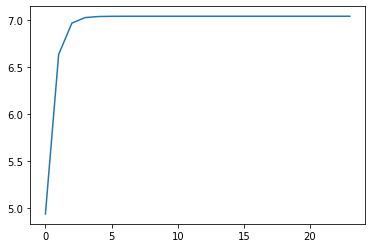

In [53]:
import matplotlib.pyplot as plt

plt.plot(decoded[20, :])
# plt.plot(samples[20, :, 0])
plt.show()

In [10]:
encoded.shape

torch.Size([50046, 16])